In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper
%aimport training_models_helper

tmh = training_models_helper.TrainingModelsHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

import recipe_helper
%aimport recipe_helper
rh = recipe_helper.Recipe_Helper()

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Becoming a successful Data Scientist

As of now, you should know
- how to construct models (the "recipe")
- how to use them for prediction
- some simple metrics on how they perform

But, to a degree, this knowledge is purely knowing the mechanics.
Perhaps having answers to the following questions is *the most important* topic from this course

- How can you *improve* your models ?
- How can you tell if your model's predictions "make sense"
- How can I be most productive ?

In this module, the topics to be covered provide answers:
- model diagnostics and interpretation

In other words: the importance of Error Aanalysis in diagnosing and improving models.

# Improving a model: study the errors

There is an old saying that you learn more from your mistakes than from your successes.

This is true in training models as well.

Hyper-focus on the Performance Metric, as is often the case, may mask subtle problems in the model.

By examining where the model succeeds and where it fails
- we may be able to improve the Performance Metric by adjusting the model to make correct predictions on previousy incorrect examples
- uncover undesirable properties of the model: bad predictions that are associated with a particular subset of examples
    - so overall Performance Metric may be good, but *always* wrong on important examples

## Model diagnostics

- Beyond summary statistics
    - for classification
    - for regression
- What is a "good" value for the summary statistic

# Running example for Beyond Accuracy: A Binary Classifier for a single MNIST digit

To illustrate some metrics deeper than Accuracy, we will focus on a specific binary classifier.


- Create a binary classifier for a single MNIST digit

In [ ]:
# Fetch the MNIST data into object
mnh.setup()

Retrieving MNIST_784 from cache


In [ ]:
# Turn the 10 class training set into a binary training set
# - Same examples, different targets
# - targets are now "is 'digit'" or "is not 'digit'" for a single digit
digit = '5'
y_train_d, y_test_d = mnh.make_binary(digit)

In [ ]:
# Fit a binary model: Is digit/Is not digit
mnh.fit(y_train=y_train_d)
cross_val_score(mnh.clf, mnh.X_train, y_train_d, cv=3, scoring="accuracy")

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(mnh.clf, mnh.X_train, y_train_d, cv=3)

y_scores = cross_val_predict(mnh.clf, mnh.X_train, y_train_d, cv=3,
                             method="decision_function")


Example run in 1.392 s


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

array([0.93821236, 0.93761248, 0.92076831])

# Classification: Beyond accuracy

We revisit the MNIST Classifier from a previous lecture in order to do a more in depth followup.

**n.b., we ran this exact code in Classification.  Still need it here**

Let's re-run the MNIST problem and examine measures of error more detailed than accuracy


Example run in 3.765 s


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

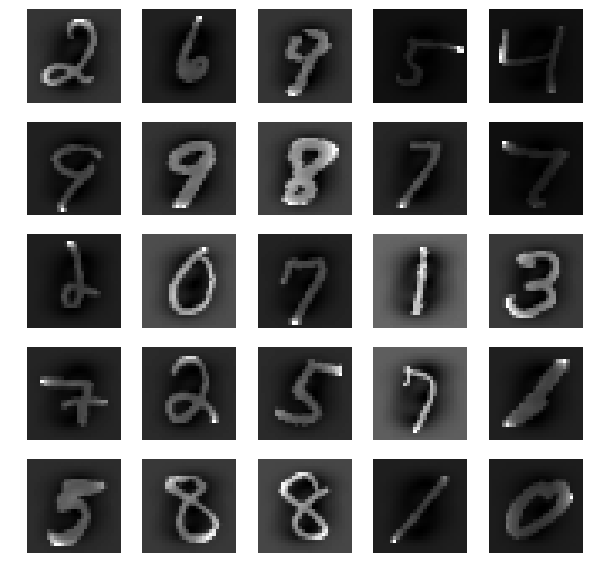

In [ ]:
mnh.setup()
mnh.visualize()
mnh.fit()

Examine the score (n.b., ran with L2 penalty)

In [ ]:
clf = mnh.clf
score = clf.score(mnh.X_test, mnh.y_test)

# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100

print("Test score with {p} penalty:{s:.4f}".format(p=clf.penalty, s=score) )
print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )

Test score with l2 penalty:0.8695
Sparsity with l2 penalty: 16.58.


We achieved an accuracy on the Test set of about 88%.

That sounds good, but is it really ?

There are two methods that we will explore to answer that question
- *Baseline model*
    - Compare our results to those obtained by a simple model (the *baseline model*)
    - If we have done no better than the simple model, then we have not achieved anything
- *Conditional Performance*
    - An analysis deeper than Unconditional Performance (e.g., Unconditional Accuracy)
    - Performance *conditional* on narrow subsets of the data
        - We can misclassify **all** test examples of a single digit and still get 90% unconditional accuracy on MNIST

## Baseline models for classification

Let's start with very weak Baseline models: ones that do **no** fitting.

Remember, our example is for the binary classifier: Is Digit/Is not Digit, for a single digit



- Most Frequent: always predict the class that occurs most frequently
- Constant: always predict Positive
- Uniform:  predict each class with equal probability (50% for binary case)
- Stratified: predict each class according to empirical distribution

In [ ]:
from sklearn.dummy import DummyClassifier

strats = { "stratified": {}, 
          "uniform": {},
          "most_frequent": {},
          "constant": {"constant": True}
         }
    
plt_num = 1

# Compute Accuracy for various baseline classifiers
for strat, args in strats.items():
    dmy_clf = DummyClassifier(strategy=strat, **args)
    acc_scores_dmy = cross_val_score(dmy_clf, mnh.X_train, y_train_d, cv=3, scoring="accuracy")
    
    print("{s}: Accuracy = {a:.2f}".format(s=strat, a=acc_scores_dmy.mean()))
   
  

stratified: Accuracy = 0.83
uniform: Accuracy = 0.50
most_frequent: Accuracy = 0.91
constant: Accuracy = 0.09


Note that we have a highly imbalanced dataset (only approximately 10% Positive examples)

This explains
- the poor accuracy of the Constant Baseline (should match the 10% of Positive examples)
- the good accuracy of the Most Frequent Basline (should match the 90% of Negative examples)
- the good accuracy of the Stratified Baseline

Remember to take the imbalance into account when evaluating the Performance metric.

If we do a little fitting, we can come up with simple, non-trivial Baseline Models.

If our "complicated" model seems to improve on the simple baseline, then (perhaps) our efforts have
achieved something.

The Naive Bayes model is a popular baseline.

## Conditional accuracy

Condition the accuracy metric on *subsets* of examples (either test or training)
- get greater insight into potential pockets of problems with our model

### Conditional accuracy: review

We briefly introduced these concepts in our Classification lecture; let's review
and then extend.

Let's examine our predictions of a binary classifier at a fine granularity via the following table

- the row labels correspond to the predicted class
- the column labels correspond to the target (actual) class

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

The correct predictions
- True Positives (TP) are  test examples predicted as Positive that were in fact Positive
- True Positives (TN) are  test examples predicted as Negative that were in fact Negative

The incorrect predictions
- False Positives (FP) are  test examples predicted as Positive that were in fact Negative
- False Positives (FN) are  test examples predicted as Negative that were in fact Positive


Unconditional Accuracy can thus be written as

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

We can also define some conditional Accuracy measures

###  Recall
- Conditioned on Positive test examples

$$
\textrm{Recall} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FN} }  }
$$
- The fraction of Positive examples that were correctly classified
- You can achieve 100% Recall by always predicting positive, but Unconditional Accuracy will suffer.
- Also goes by the names: True Positive Rate (TPR), Sensitivity

### Specificity
- conditioned on Negative examples

$$
\textrm{Specificity} = { { \textrm{TN} } \over { \textrm{TN} +  \textrm{FP} }  }
$$

- The fraction of Negative examples that were correctly classified
- Also goes by the name: True Negative Rate (TNR)

### Precision
A metric to tell you the fraction of your Positive predictions that were correct.

$$
\textrm{Precision} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FP} }  }
$$

There is a degenerate case of perfect precision:
- predict "Positive" for only a single, known actual positive
- 100% precision, but you fail to correctly predict most actual positives

### False Positive Rate
$$
\begin{array}{lll}
\textrm{FPR} & = & { { \textrm{FP} } \over { \textrm{FP} + \textrm{TN} } } \\
             & = & 1 - \textrm{Sensitivity}
\end{array}
$$

## Precison/Recall Tradeoff

Some Classification models (e.g., Logistic Regression) have hyperparameters
that compare numerical "scores" to a threshold in order to make a prediction.

By varying the threshold, we can change predictions to favor a particular Conditional Performance metric.

We will show how this happens and demonstrate ways to evaluate the tradeoff between metrics.

Recall our methodology for Classification via Logistic Regression:
- Compute a "score" that our example is in each of the target classes
- Construct a probability distribution (over the target classes) from the scores
    - convert the per class score into a probability via the sigmoid/softmax function
- Compare the probability to a threshhold

$$\hat{p} = \sigma(\Theta^T \x)  $$
where $\sigma$,  the *logistic function*, is:

Convert $\hat{p}^\ip$ into Classification prediction $\hat{y}^\ip$

$$
\hat{y}^\ip = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{p}^\ip < 0.5   & \text{Negative} \\
    1 & \textrm{if } \hat{p}^\ip \ge 0.5  & \text{Positive} \\
    \end{array}
    }
\right.
$$

We can affect the prediction of Positive/Negative by varying the choice of Threshhold.

We can increase the number of Positive predictions by lowering the threshhold
- this will increase TP
    - increase Recall by increasing numerator
    - degenerate case: *always* predict Positive !
- but also increase  FP
    - no effect on Recall (FP *does not* appear in denominator)
    - which decreases Precision (where FP *does* appear in the denominator)
    
So there is a tradeoff between Recall and Precision that is determine by our choice of threshold.

**Precision vs Recall: which one to favor ?**

- Depending on the context, you may favor Precision over Recall, or vice-versa:
    - Favor Precision when a False Positive is undesirable
        - FP: mistakenly tell someone they are in trouble
    - Favor Recall when False Negative is undesirable
        - FN: mistakenly fail to identify a highly-communicable disease

Why would we want to increase Recall (at the potential cost of decreased unconditional Accuracy) ?

It depends on your task.

Consider a diagnostic test for an extremely dangerous, infectious disease
- It might very important to have high Recall (catch truly infected patients)
- Even at the expense of incorrectly labelling some healthy patients as infected

By *decreasing* the threshold we increase the number of Positive predictions
- Recall increases (by increasing TP)
- Precision decreases (by increasing FP)


By *raising* the threshhold, we can decrease the number of Positive predictions.
- Potentially decrease Recall (by decreasing TP)
- Increase Precision (by decreasing FP)

Decreasing the number of Positive predictions increases the number of Negatives
- Complementary effect on the Negative counterparts of the Positive metrics (Recall:Specificity)
- Increase Specificity (by decreasing FP, we increase TN)

Why would we want to increase Specificity (potentially decreasing unconditional Accuracy) ?
- decrease Unconditional Accuracy by increasing the False Negatives (FN)

Consider a diagnostic test for a mild, non-infectious disease
- A Positive prediction might entail an expensive/painful remedy, which we want to avoid
- Even at the expense of incorrectly labelling some non-healthy patients as healthy
   

### Precision/Recall tradeoff: plot

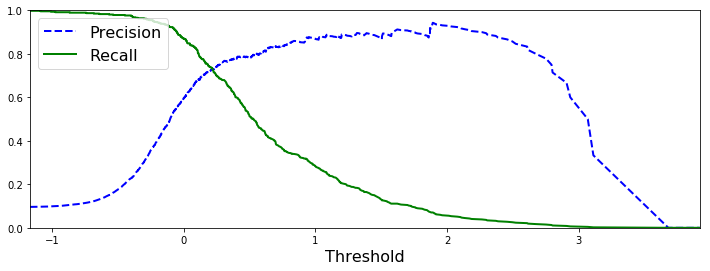

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_d, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    _ = ax.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = ax.set_xlabel("Threshold", fontsize=16)
    _ = ax.legend(loc="upper left", fontsize=16)
    _ = ax.set_ylim([0, 1])
    
    return fig, ax

fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
_ = ax.set_xlim([ thresholds.min(), thresholds.max()])

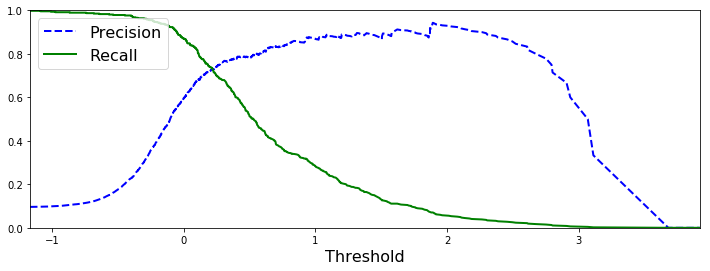

In [ ]:
fig

You can see how varying the threshold (units is log odds ?) affects Recall and Precision
- one at the expense of the other

### ROC/AUC: Evaluating the Precision/Recall tradeoff

The **ROC** plots the True Positive Rate (TPR) versus the False Positive Rate (FPR).

The resulting curve helps us choose a threshold.

Our goal is to get a high TPR with a low FPR.

This corresponds to the Area Under the Curve being as high as possible, as we will see in the plots.

Here's how it works
- fit a binary classifier
- predict on a dataset (e.g., test)
    - this gives a vector of probabilities for each example
    - classifier predicts Positive if corresponding probability exceeds a threshold
- vary the threshold between 0 and 1
    - each threshold value gives a TPR and FPR

We illustrate with a couple of classifiers for the binary MNIST digit classification problem.

**Geron page 128** When to prefer Precision/Recall curve to AUC

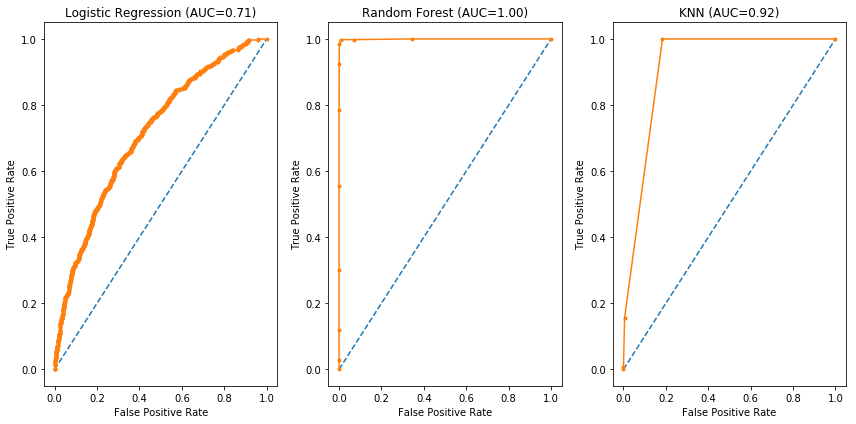

In [ ]:
# ROC curves for binary classifier: Is Digit/Is not Digit
clh.AUC_plot(X_train=mnh.X_train, y_train=y_train_d, X_test=mnh.X_train, y_test=y_train_d)


You can see the results of 
- Logistic Regression
- KNN
- Random Forests

### $F_1$: Another way to combine Precision and Recall

There is a simple metric to combine
 Precision and Recall into a single number:

$$
\textrm{F}_1 = { { \textrm{TP} } \over { \textrm{TP} +  { { \textrm{FN} + \textrm{FP} }   \over 2 } }  }
$$

## Regression: beyond RMSE/$R^2$

We just spent time developing methods to study errors of classification.

What is the analog for Regression ?

Examining the residuals.

Coefficients: 
 [9.86448852] [[0.93673892]]


R-squared (test): 0.91
Root Mean squared error (test): 13.73


R-squared (train): 0.91
Root Mean squared error (train): 13.13


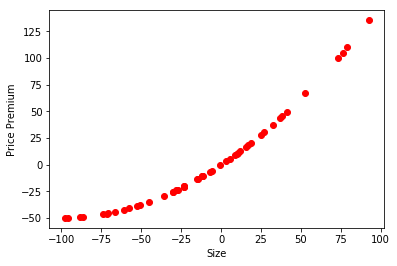

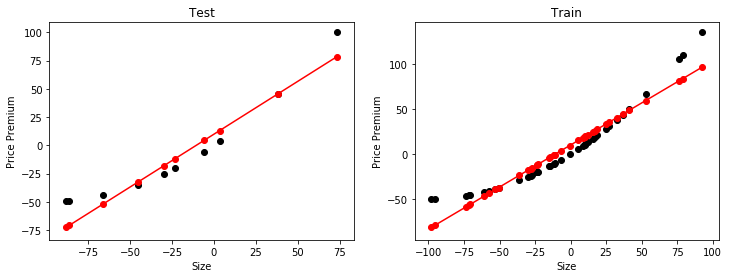

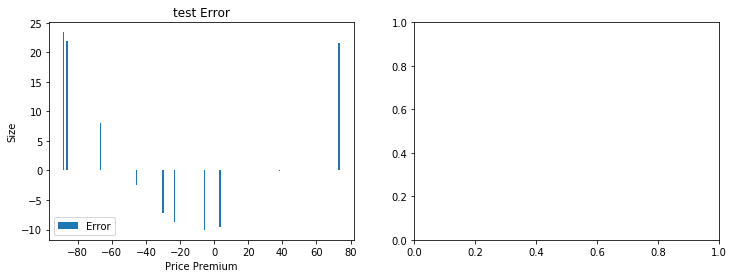

In [ ]:
v1, a1 = 1, .005
v2, a2 = v1, a1*2
(xlabel, ylabel) = ("Size", "Price Premium")

X_curve, y_curve = rh.gen_data(num=50, v=v2, a=a2)
figp, axp = rh.gen_plot(X_curve,y_curve, xlabel, ylabel)

fig, axs = rh.regress_with_error(X_curve, y_curve, xlabel=xlabel, ylabel=ylabel)

Let's focus on the errors.

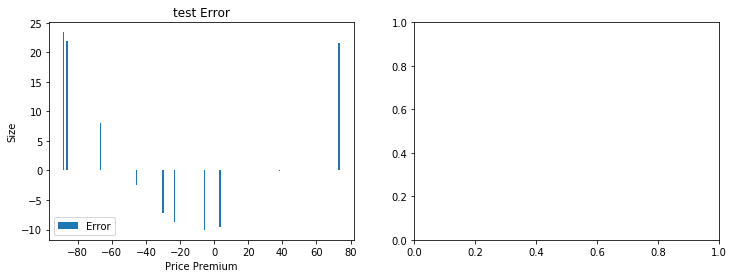

In [ ]:
fig

Not good !
- clear pattern: errors increase in the tails
- not constant variance

Recall that our conclusion was that there was a missing feature: a higher order $x^2$ term.

Once we added that term, the target became linear in 
$$ \Theta^T \cdot X = \beta_1 *x + \beta_2 * x^2$$

# Beyond accuracy for full MNIST

We perform a deep-dive on the results of the full 10 class MNIST Logistic Regression classifier.

We illustrate the multitude of tools that an enterprising Data Scientist can use
beyond Accuracy.

Let's start by fitting the model.

In [ ]:
mnh.fit()

Let's examine the Confusion Matrix for potential issues

In [ ]:
# Now predict the value of the digit on the second half:
confusion_mat = mnh.create_confusion_matrix()

digits = range(0,10)
_= clh.plot_confusion_matrix(confusion_mat, digits, normalize=True)

- You can see that we didn't do equally well for all digits
    - "5", "8": below 80% correctly classified
    - "2", "3", "9": 80%-90% correctly classified
    
- Questions:
    - Are the errors acceptable ?
    - What can we do about the errors ?

We will perform some diagnostics on the classification of a *single* digit.

If we pick up a pattern on examples for this digit that have been misclassified
- we have identified a cause (commonality of problem examples)
- might be able to improve the model by feature engineering
    - hand-engineer a feature for the problem cases

Consider the multinomial MNIST classification problem with class $C = \{ 
\text{'0', '1'}, \ldots, \text{'9'} \}$

Let $D \in C$ be a particular digit that we wish to focus on.

Perhaps this is a digit for which the confusion matrix shows problems.

We will look at *accuracy conditional on* correct label being $D$.
- we turn the results of the multinomial classifier into a binary classifier with class $C' = \{ \text{Is D}, \text{Is not D} \}$

So we are essentially testing the Recall of digit $D$.

Let's see some examples of misclassified digits.

In [ ]:
problem_digits = [ '5', '8', '2', '3', '9' ]

mnh.plot_problem_digits( problem_digits )

The first row shows the misclassified 5's.

Why were they mis-classified ?

It's possible that the probability of the incorrect class was barely above the correct one.

Was that the case here ?

Let's examine the probability vector $\hat{p}$ predicted for a number of examples.

**Note**
The prediction is the class at index $i$ where 
$$i = \argmax{j} \hat{p}_j$$

In [ ]:
# Select some mis-classified "5"'s'
problems = mnh.misclassified["5"][ [2,3,4] ]
mnh.predict_with_probs(problems, digits)

Examining the probabilities: 
- the predicted class had highest probability; was the correct class probability even close ?
- what were the other potential candidate classes ?

Any theories why the misclassification occured ?

That would be the first step in fixing the problem
- perhaps some feature engineering would help

In the Deep Learning part of the course, we will show how the decision of a classifier may be "explained".

The techniques might help here, in the Classical setting, as well.

Let's narrow our focus to a single misclassified digit in
an attempt to gain more insight.

The digit 8 seems to get misclassified as the digit 1.  Let's explore.

In [ ]:
mnh.plot_problem_digits( ['8'], wrong_class='1', num_cols=10)


- Is the strong vertical part in the center the problem ?
- Are small black holes a problem ?

Now that you can visualize the "problems", can you think of ways to improve the prediction ?

We didn't offer any answers or potential solutions.

Our goal was merely to show
- that you *don't have to stop* with a summary statistic
- you don't need a specialized package to examine errors

Error analysis is what separates an adequate Data Scientist from a successful one.

In [ ]:
print("Done")